# Compare analog forecast skills

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import xarray as xr
import proplot as pplt
import cartopy.crs as ccrs

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from loadstats import *
xr.set_options(keep_attrs=True)

In [2]:
# Set experiments to analyze
exps = ['MA', 'test']          # Output directories
epochs = [None, None]          # Use the best epoch
exp_names = ['MA', 'DL + MA']  # Labels

# parameters
vname = 'sst'
test_data = 'test'
data_dir = '../data/cesm2'

# test_data = 'real'
# data_dir = '../data/real'

# Month
out_dir = f'../output/{exps[-1]}'
with open(f'{out_dir}/hyperparameters.json', 'r') as f:
    hp = json.load(f)
    hp = DotDict(hp)
month = hp.month

# Read

In [3]:
xy_stats = load_stats('xy_stats', exps, exp_names, epochs, vname, test_data, month)
t_stats = load_stats('t_stats', exps, exp_names, epochs, vname, test_data, month)
t_crps = load_stats('t_crps', exps, exp_names, epochs, vname, test_data, month)
t_std = load_stats('t_std', exps, exp_names, epochs, vname, test_data, month)
nino_mse = load_stats('t_mse', exps, exp_names, epochs, 'nino', test_data, month)
nino_uac = load_stats('t_uac', exps, exp_names, epochs, 'nino', test_data, month)
nino_crps = load_stats('t_crps', exps, exp_names, epochs, 'nino34', test_data, month)
nino_std = load_stats('t_std', exps, exp_names, epochs, 'nino', test_data, month) 

# Combine
t_stats = xr.merge([t_stats, (t_std['std']**2).rename('var')])

In [4]:
%%time
# Read 2x2 data
f = f'{data_dir}/sst_anomaly_2x2.nc'
da = xr.open_dataarray(f)

# Nino
nino = nino_indices(da)
nino_month = extract_month_and_to_yearly(nino, month).sel(year=xy_stats.year)

# Nino next year
nino_ny = shift_time(nino, 12)
nino_ny_month = extract_month_and_to_yearly(nino_ny, month).sel(year=xy_stats.year)

# Nino threshold
nino_threshold = nino_month['nino34'].std().data * 0.5
print(nino_threshold)

0.8344855203314219
CPU times: user 793 ms, sys: 9.14 s, total: 9.93 s
Wall time: 9.98 s


# Aggregate

In [5]:
# stats difference
t_stats_diff = t_stats.isel(exp=slice(1, None)) - t_stats.isel(exp=0)

# Time & space stats
wgt = np.cos(np.deg2rad(t_stats.lat))
txy_stats = t_stats.sel(
    lat=slice(-10, 10), lon=slice(120, 290)).weighted(wgt).mean(dim=['lat', 'lon'])                 
txy_crps = t_crps.sel(
    lat=slice(-10, 10), lon=slice(120, 290)).weighted(wgt).mean(dim=['lat', 'lon'])

# RMSE & Ensemble spread
txy_stats['rmse'] = txy_stats['mse'] ** 0.5
txy_stats['std'] = txy_stats['var'] ** 0.5

# RMSE difference
xy_stats['drmse'] = xy_stats['mse'].isel(exp=0)**0.5 - xy_stats['mse'].isel(exp=slice(1, None))**0.5
xy_stats['dmse'] = xy_stats['mse'].isel(exp=0) - xy_stats['mse'].isel(exp=slice(1, None))

# RMSE skills
t_stats['nrmse'] = (1 - t_stats['mse'].isel(exp=slice(1, None))**0.5/t_stats['mse'].isel(exp=0)**0.5) * 100
xy_stats['nrmse'] = (1 - xy_stats['mse'].isel(exp=slice(1, None))**0.5/xy_stats['mse'].isel(exp=0)**0.5) * 100
txy_stats['nrmse'] = (1 - txy_stats['mse'].isel(exp=slice(1, None))**0.5/txy_stats['mse'].isel(exp=0)**0.5) * 100
nino_nrmse = (1 - nino_mse.isel(exp=slice(1, None))**0.5/nino_mse.isel(exp=0)**0.5) * 100

# Plot

In [6]:
cycle = pplt.Cycle(['k', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7'])

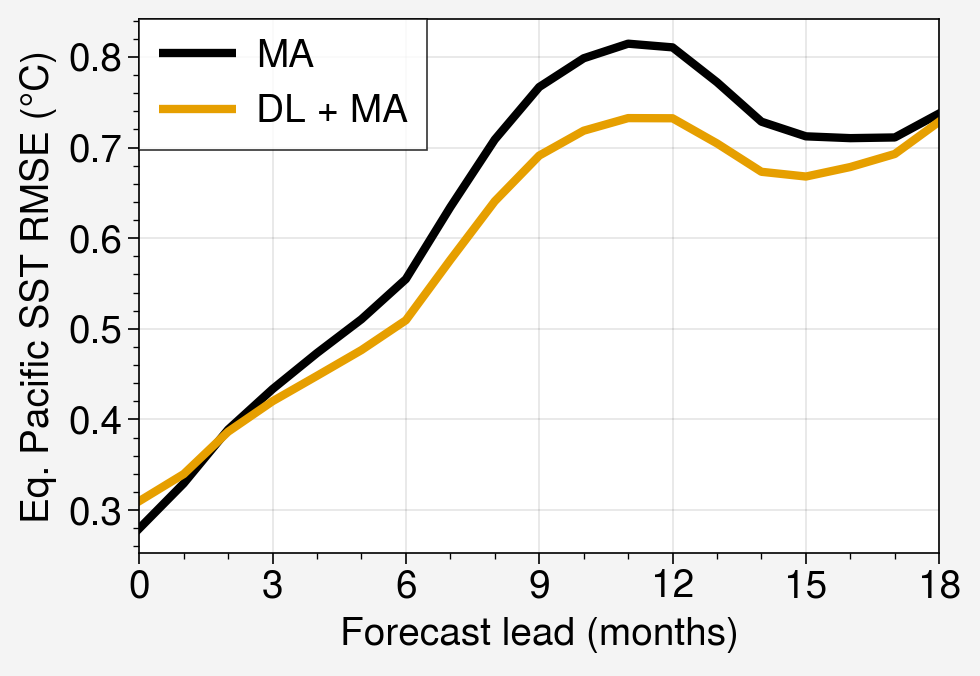

In [7]:
fig, ax = pplt.subplots(refaspect=1.5, refwidth=4)

ax.plot(txy_stats['rmse'], lw=3, cycle=cycle)

ax.legend(frame=True, ncol=1)

ax.format(
    ylabel='Eq. Pacific SST RMSE (°C)',
    xlabel='Forecast lead (months)',
    xlocator=3,
    xminorlocator=1,
)

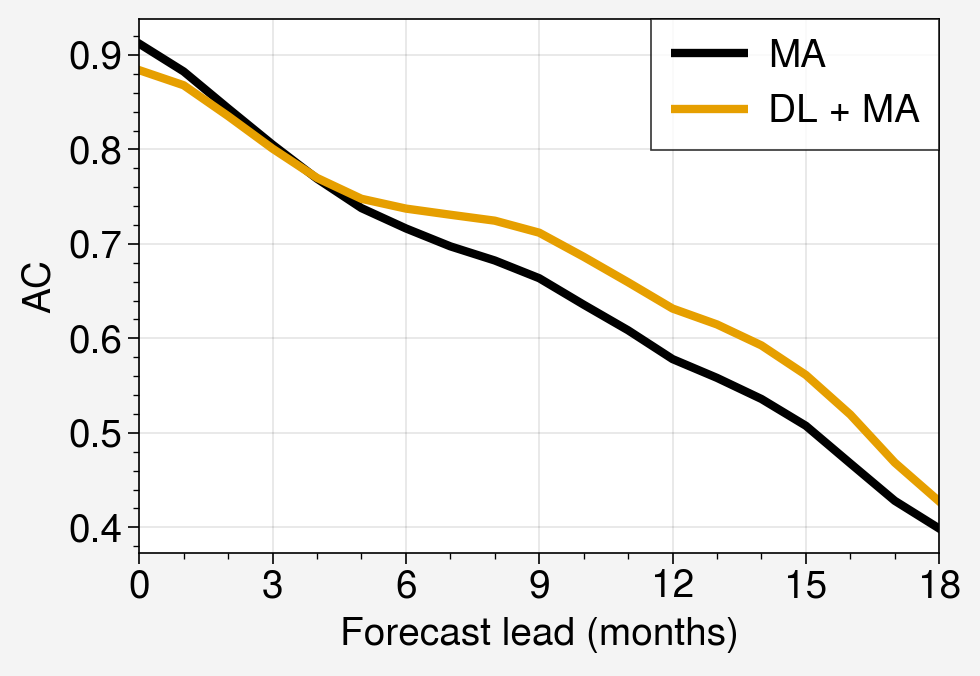

In [8]:
fig, ax = pplt.subplots(refaspect=1.5, refwidth=4)

ax.plot(txy_stats['uac'], lw=3, cycle=cycle)

ax.legend(frame=True, ncol=1)

ax.format(
    ylabel='AC',
    xlabel='Forecast lead (months)',
    xlocator=3,
    xminorlocator=1,
)

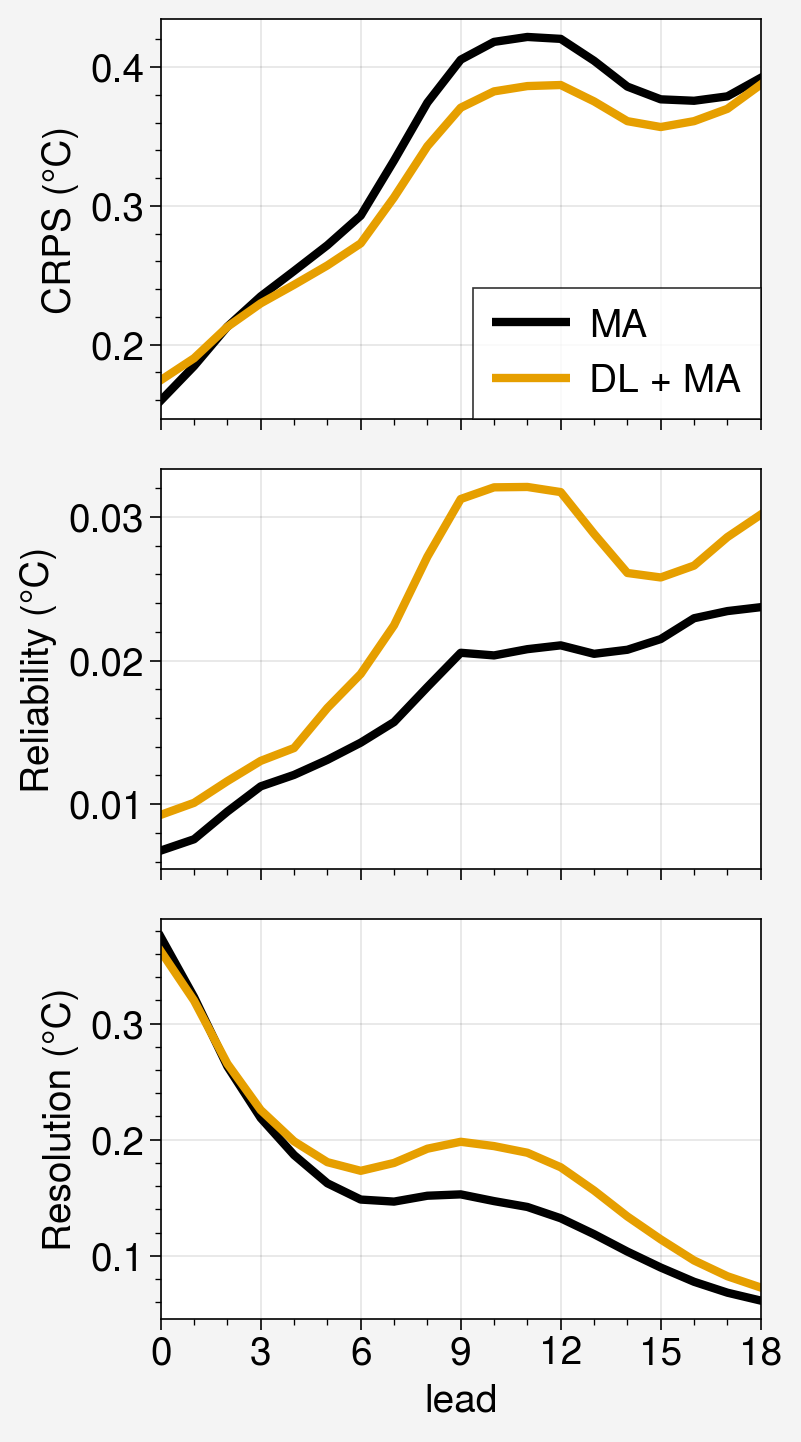

In [9]:
fig, axs = pplt.subplots(nrows=3, refaspect=1.5, refwidth=3, spany=False)

for ax, sname in zip(axs, ['crps', 'rel', 'res']):
    ax.plot(txy_crps[sname], lw=3, cycle=cycle)
    ax.format(ylabel=f"{t_crps[sname].attrs['long_name']} (°C)")

axs[0].legend(frame=True, ncol=1)

ax.format(
    xlabel='Forecast lead (months)',
    xlocator=3,
    xminorlocator=1,
)

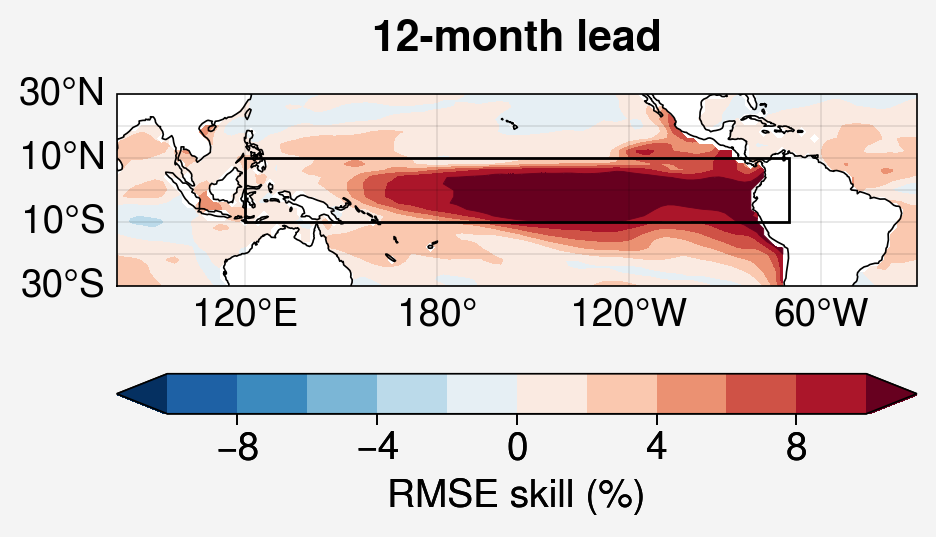

In [10]:
lead = 12
fig, axs = pplt.subplots(nrows=len(exps)-1, axwidth=4, proj='cyl', proj_kw={'lon_0': 210})

for exp_name, ax in zip(exp_names[1:], axs):
    m = ax.contourf(t_stats.sel(exp=exp_name, lead=lead)['nrmse'], 
                    levels=np.linspace(-10, 10, 11), extend='both',
                    globe=True,
                    )
    #ax.colorbar(m, loc='b')
    #ax.format(title=exp_name)
    ax.fill([120, 290, 290, 120], [-10, -10, 10, 10], fill=False,
        lw=1, transform=ccrs.PlateCarree())

fig.colorbar(m, loc='b', label='RMSE skill (%)')    
axs.format(
    coast=True, 
    suptitle=f'{lead}-month lead',
    #latlim=(-15, 15), lonlim=(115, 285),
    latlim=(-30, 30), lonlim=(80, 330),
    #latlines=10,
    #lonlines=30,
)
axs[-1,:].format(lonlabels=True)
axs[:,0].format(latlabels=True)

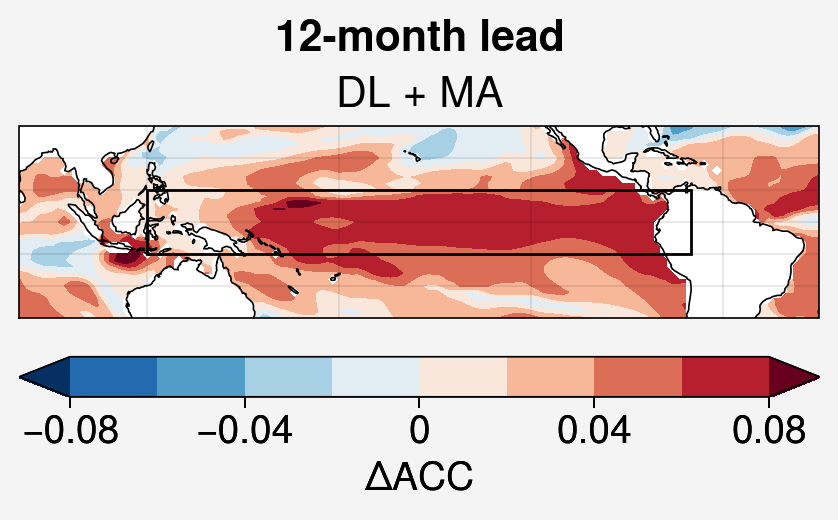

In [11]:
lead = 12
fig, axs = pplt.subplots(nrows=len(exps)-1, axwidth=4, proj='cyl', proj_kw={'lon_0': 210})

for exp_name, ax in zip(exp_names[1:], axs):
    m = ax.contourf(t_stats_diff.sel(exp=exp_name, lead=lead)['uac'], 
                    levels=np.linspace(-.08, .08, 9), extend='both',
                    #levels=np.linspace(-.04, .08, 13), 
                    # levels=np.linspace(0, .08, 9), 
                    globe=True,
                    )
    #ax.colorbar(m, loc='b')
    ax.format(title=exp_name)

    ax.fill([120, 290, 290, 120], [-10, -10, 10, 10], fill=False,
            lw=1, transform=ccrs.PlateCarree())

fig.colorbar(m, loc='b', label=r'$\Delta$ACC')    
axs.format(
    coast=True, 
    suptitle=f'{lead}-month lead',
    #latlim=(-15, 15), lonlim=(115, 285),
    latlim=(-30, 30), lonlim=(80, 330),
    #latlim=(-60, 60),
    #latlines=10,
    #lonlines=30,
)
#axs[-1,:].format(lonlabels=True)
#axs[:,0].format(latlabels=True)

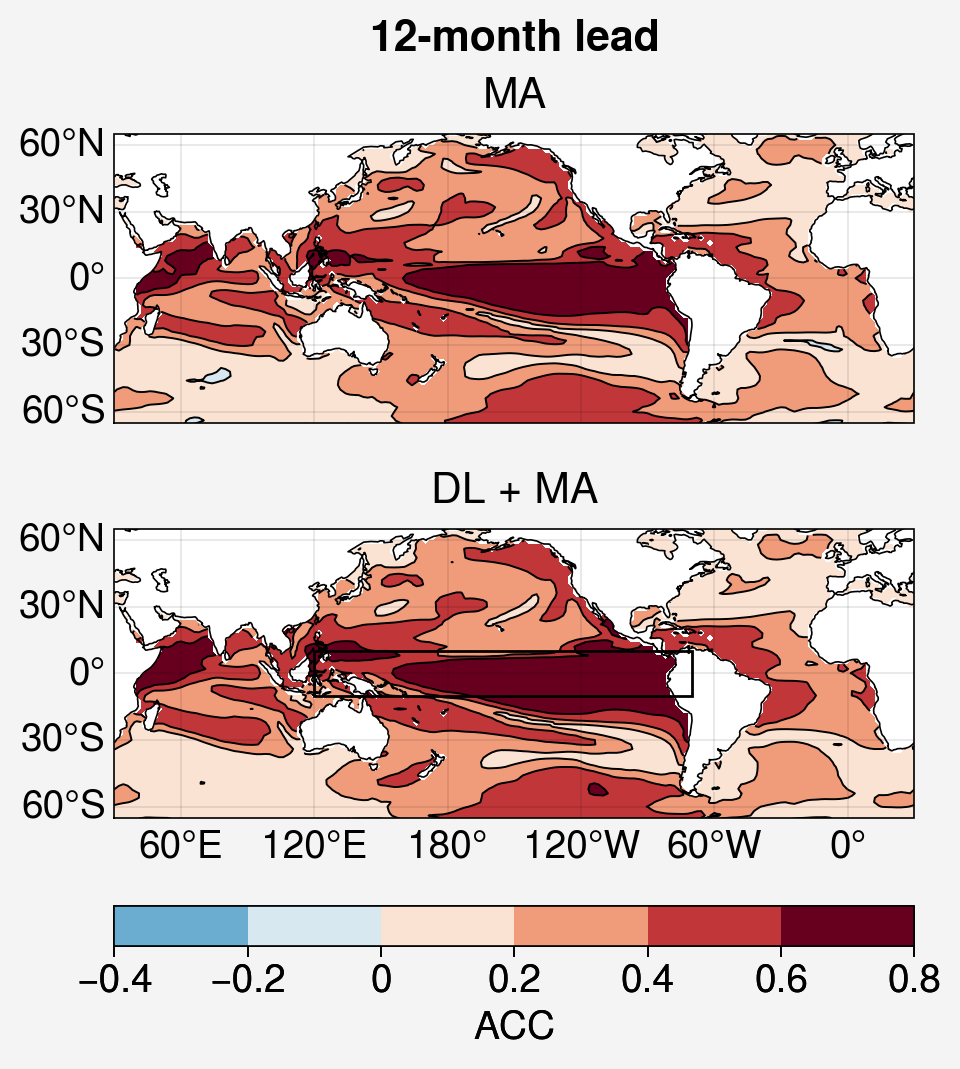

In [12]:
lead = 12
fig, axs = pplt.subplots(nrows=len(exps), axwidth=4, proj='cyl', proj_kw={'lon_0': 210})

for exp_name, ax in zip(exp_names, axs):
    m = ax.contourf(t_stats.sel(exp=exp_name, lead=lead)['uac'],
                    #levels=np.linspace(-.4, .7, 12),
                    #levels=np.linspace(.3, .8, 6), extend='min', cmap=pplt.Colormap('fire', left=.1),
                    #levels=np.linspace(-.6, .75, 10), 
                    levels=np.linspace(-.4, .8, 7), 
                    lw=.7,
                    globe=True,
                    )
    # ax.contour(uac.sel(exp=exp_name, lead=lead),
    #            levels=[0.3], c='k',
    #            )                
    #ax.colorbar(m, loc='b')
    ax.format(title=exp_name)

# ax.fill([40, 110, 110, 40], [-20, -20, 20, 20], fill=False,
#         lw=1, transform=ccrs.PlateCarree())
# ax.fill([40, 270, 270, 40], [-20, -20, 20, 20], fill=False,
#         lw=1, transform=ccrs.PlateCarree())

ax.fill([120, 290, 290, 120], [-10, -10, 10, 10], fill=False,
        lw=1, transform=ccrs.PlateCarree())

fig.colorbar(m, loc='b', label='ACC')    
axs.format(
    coast=True, 
    suptitle=f'{lead}-month lead',
    #latlim=(-15, 15), lonlim=(115, 285),
    latlim=(-65, 65),
    latlines=30,
)
axs[-1,:].format(lonlabels=True)
axs[:,0].format(latlabels=True)

# Skill as a function of Nino

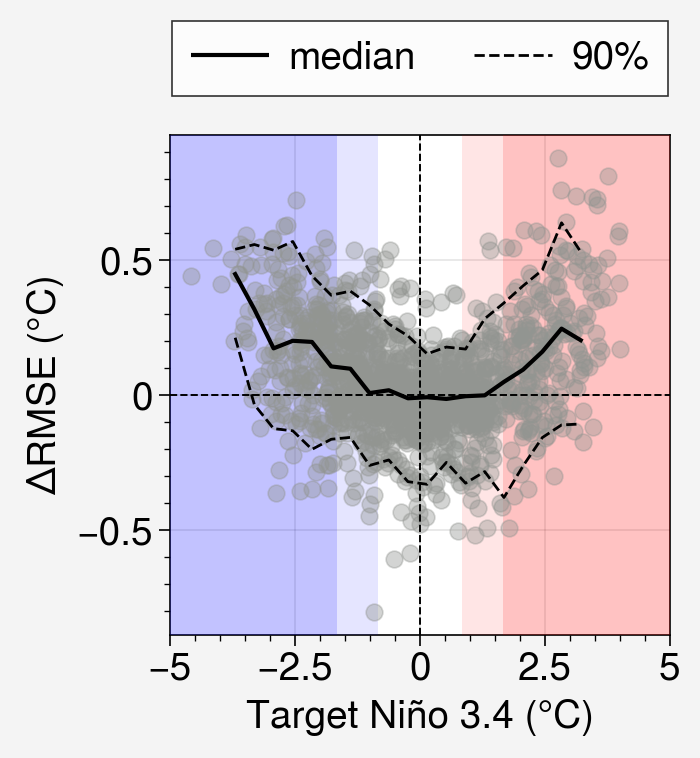

In [13]:
lead = 12
if test_data == 'test':
    xlim = 5
else:
    xlim = 3

fig, axs = pplt.subplots(ncols=len(exps)-1)
for exp_name, ax in zip(exp_names[1:], axs):
    x = nino_ny_month['nino34'].data.ravel()
    y = xy_stats['drmse'].sel(lead=lead, exp=exp_name).data.ravel()

    ax.scatter(x, y, c='gray', alpha=0.4, zorder=10)
    
    # idx = (xy_dmse.sel(lead=lead, exp=exp_name) 
    #        > xy_dmse.sel(lead=lead, exp=exp_name).quantile(0.9))
    # ax.scatter(nino_ny_month['nino34'].where(idx), 
    #            xy_dmse.sel(lead=lead, exp=exp_name).where(idx), 
    #            c='r', alpha=0.4, zorder=20)

    if test_data == 'test':
        xbins = np.linspace(x.min()*0.85, x.max()*0.85, 20)
        xbin_center = (xbins[:-1] + xbins[1:])/2
        lst = []
        for xmin, xmax in zip(xbins[:-1], xbins[1:]):
            # print(xmin, xmax)
            idx = (x >= xmin) & (x < xmax)
            y_samples = y[idx]
            lst.append(np.quantile(y_samples, [0.05, 0.5, 0.95]))
        y_df = pd.DataFrame(np.array(lst), columns=[0.05, 0.5, 0.95], index=xbin_center)
        h1 = ax.plot(y_df[0.5], c='k', zorder=30, label='median')
        h2 = ax.plot(y_df[0.05], c='k', ls='--', lw=1, zorder=30, label='90%')
        ax.plot(y_df[0.95], c='k', ls='--', lw=1, zorder=30)
    
    ax.axhline(0, c='k', ls='--', lw=.7, zorder=15)
    ax.axvline(0, c='k', ls='--', lw=.7, zorder=15)
    # ax.format(ltitle=exp_name)
    ax.axvspan(-xlim, -nino_threshold, fc='b', alpha=0.1, zorder=3)
    ax.axvspan(-xlim, -nino_threshold*2, fc='b', alpha=0.15, zorder=3)

    ax.axvspan(nino_threshold, xlim, fc='r', alpha=0.1, zorder=3)
    ax.axvspan(nino_threshold*2, xlim, fc='r', alpha=0.15, zorder=3)

fig.legend(h1+h2, ncol=2, loc='t')
axs.format(
    ylabel=r'$\Delta$RMSE (°C)',
    # ylabel=r'$\Delta$MSE $(°C^2)$',
    xlabel='Target Niño 3.4 (°C)',
    xlim=(-xlim, xlim),
)